# Importing Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

plt.style.use('fivethirtyeight')
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
# Update the default rc settings
plt.rcParams['figure.facecolor'] = 'white'  # Figure background
plt.rcParams['axes.facecolor'] = 'white'    # Axes background

## Reference for the physics of golf ball flight
https://www.math.union.edu/~wangj/courses/previous/math238w13/Golf%20Ball%20Flight%20Dynamics2.pdf

##  Reference for driver distance
https://www.pgatour.com/stats/detail/101

## Driving Distance

The average number of yards per measured drive. These drives are measured on two holes per round. Care is taken to select two holes which face in opposite directions to counteract the effect of wind. Drives are measured to the point at which they come to rest regardless of whether they are in the fairway or not. (101)




# Constants

In [3]:
# Constants
g = 9.81  # m/s^2, acceleration due to gravity
rho = 1.225  # kg/m^3, air density
C_d = 0.25  # drag coefficient for a dimpled golf ball
C_l = 0.2  # lift coefficient (simplified, can be tuned based on spin rate)
A = 0.001432  # m^2, cross-sectional area of the golf ball (diameter approx. 42.67 mm)
m = 0.04593  # kg, mass of the golf ball
dt = 0.01  # time step in seconds

# Initial Conditions

In [4]:
# Initial conditions
v0 = 76.4  # m/s
angle = 10.4  # degrees, typical driver angle of PGA pros
theta = np.radians(angle)
v_x = v0 * np.cos(theta)
v_y = v0 * np.sin(theta)
x, y = 0, 0  # initial position

# Runge-Kutta Integration Functions


In [5]:
# Function to calculate derivatives for Runge-Kutta
def derivatives(v_x, v_y):
    v = np.sqrt(v_x**2 + v_y**2)
    F_d = 0.5 * C_d * rho * A * v**2
    F_l = 0.5 * C_l * rho * A * v**2
    F_d_x = F_d * (v_x / v)
    F_d_y = F_d * (v_y / v)
    F_l_x = -F_l * (v_y / v)
    F_l_y = F_l * (v_x / v)
    dv_x_dt = -F_d_x / m
    dv_y_dt = -g + F_l_y / m - F_d_y / m
    return dv_x_dt, dv_y_dt

# Runge-Kutta integration function
def runge_kutta_step(v_x, v_y, x, y, dt):
    k1_vx, k1_vy = derivatives(v_x, v_y)
    k2_vx, k2_vy = derivatives(v_x + 0.5 * k1_vx * dt, v_y + 0.5 * k1_vy * dt)
    k3_vx, k3_vy = derivatives(v_x + 0.5 * k2_vx * dt, v_y + 0.5 * k2_vy * dt)
    k4_vx, k4_vy = derivatives(v_x + k3_vx * dt, v_y + k3_vy * dt)
    v_x_next = v_x + (k1_vx + 2 * k2_vx + 2 * k3_vx + k4_vx) * dt / 6
    v_y_next = v_y + (k1_vy + 2 * k2_vy + 2 * k3_vy + k4_vy) * dt / 6
    x_next = x + v_x * dt
    y_next = y + v_y * dt
    return v_x_next, v_y_next, x_next, y_next

# Simulate Trajectories Given Desired Range and Launch Angle

In [6]:
# Function to simulate trajectory and return the range
def simulate_trajectory(v0, angle_degrees):
    theta = np.radians(angle_degrees)
    v_x = v0 * np.cos(theta)
    v_y = v0 * np.sin(theta)
    x, y = 0, 0  # initial position

    while y >= 0:

        # Calculate the speed of the ball
        v = np.sqrt(v_x**2 + v_y**2)
        
        # Calculate the drag force magnitude (using quadratic drag equation)
        F_d = 0.5 * C_d * rho * A * v**2
        
        # Calculate the lift force magnitude (using lift force equation)
        F_l = 0.5 * C_l * rho * A * v**2
        
        # Decompose the drag force into horizontal (x) and vertical (y) components
        F_d_x = F_d * (v_x / v)
        F_d_y = F_d * (v_y / v)
        
        # Decompose the lift force into horizontal (x) and vertical (y) components
        F_l_x = -F_l * (v_y / v)
        F_l_y = F_l * (v_x / v)
        
        # Update horizontal velocity considering drag force
        v_x -= (F_d_x / m) * dt
        
        # Update vertical velocity considering gravity, drag, and lift forces
        v_y -= (g + (F_d_y / m) - (F_l_y / m)) * dt
        
        # Update the position of the golf ball
        x += v_x * dt
        y += v_y * dt
    
    return x  # Return the horizontal range

# Objective function to minimize the difference between the simulated range and desired range
def objective_function(v0, angle_degrees, desired_range):
    simulated_range = simulate_trajectory(v0, angle_degrees)
    return abs(simulated_range - desired_range)

# Function to find initial velocity given the desired range and launch angle
def find_initial_velocity(desired_range, launch_angle):
    initial_guess = 50  # Initial guess for velocity in m/s
    result = minimize(objective_function, initial_guess, args=(launch_angle, desired_range), bounds=[(0, 150)])
    return result.x[0]


# Unit conversions

In [7]:
def to_meters_from_yards(distance):
    return distance * 0.9144
def to_yards_from_meters(distance):
    return distance / 0.9144

# Get PGA Driver Data

In [8]:
df = pd.read_csv('pga_avg_drive_distance.csv')
df.drop('Unnamed: 1', axis=1, inplace=True)
df.head()

# quantiles / distances in yards
shortest = df['AVG'].min()
lower = df['AVG'].quantile(0.25)
middle = df['AVG'].quantile(0.50)
upper = df['AVG'].quantile(0.75)
longest = df['AVG'].max()

print(shortest, lower, middle, upper, longest)

275.8 293.0 298.45 304.29999999999995 318.3


# Find Trajectories

In [9]:
# define bounds of chart, driving distances in meters
max_bound = to_meters_from_yards(longest)
upper_bound = to_meters_from_yards(upper)
middle_bound = to_meters_from_yards(middle)
lower_bound = to_meters_from_yards(lower)
min_bound = to_meters_from_yards(shortest)  

bounds = {'min':min_bound,'lower':lower_bound,'middle':middle_bound,'upper':upper_bound,'max':max_bound}

# dictionary to store trajectories for each bound
trajectories_x = {'min':[],'lower':[],'middle':[],'upper':[],'max':[]}
trajectories_y = {'min':[],'lower':[],'middle':[],'upper':[],'max':[]}

# find the trajectories for each of the bounds
for bound_name, bound_range in bounds.items():
    # find the initial velocity in m/s associated with the bound and break it into x,y components
    v0 = find_initial_velocity(bound_range, angle)
    v_x = v0 * np.cos(theta)
    v_y = v0 * np.sin(theta)

    x, y = 0, 0  # initial position

    # Simulation loop
    while y >= 0:
        v_x, v_y, x, y = runge_kutta_step(v_x, v_y, x, y, dt)
        # convert trajectories back to yards and append to the appropriate list
        trajectories_x[bound_name].append(to_yards_from_meters(x))
        trajectories_y[bound_name].append(to_yards_from_meters(y))


In [10]:
print(np.max(trajectories_x['max']))
print(np.max(trajectories_x['min']))

319.67204277803523
277.07253566242804


# Plot Trajectories

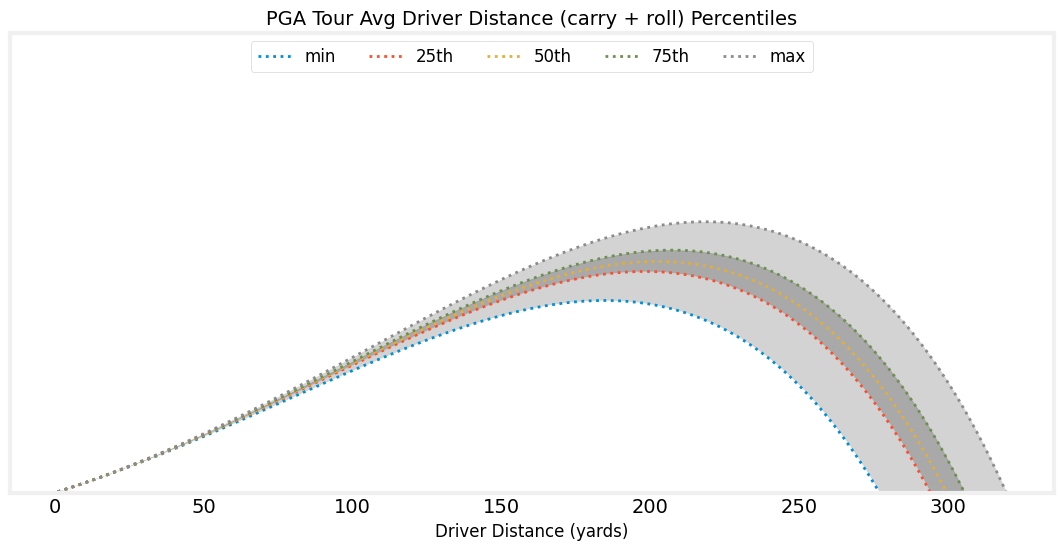

In [27]:
plt.figure(figsize=(12,5))
# plot background color white
# plt.style.use('_mpl-gallery')

# Plot the trajectories for each bound
for bound_name, bound_range in bounds.items():
    plt.plot(trajectories_x[bound_name], trajectories_y[bound_name], label=bound_name,linestyle='dotted',linewidth=2)
# Fill between each curve and the x-axis
plt.fill_between(trajectories_x['max'], trajectories_y['max'], color='lightgray', alpha=1)
plt.fill_between(trajectories_x['upper'], trajectories_y['upper'], color='gray', alpha=0.5)
# plt.fill_between(trajectories_x['middle'], trajectories_y['middle'], color='gray', alpha=0.3)
plt.fill_between(trajectories_x['lower'], trajectories_y['lower'], color='lightgray', alpha=1)
plt.fill_between(trajectories_x['min'], trajectories_y['min'], color='white', alpha=1)


plt.ylim(0,90)
plt.title('PGA Tour Avg Driver Distance (carry + roll) Percentiles', size=14)
plt.xlabel('Driver Distance (yards)',size=12)
# plt.ylabel('Vertical Distance (m)')
plt.yticks([])
plt.grid(False)

plt.legend(labels=['min','25th','50th','75th','max'],loc='upper center',ncol=5,fontsize=12)
plt.show()